In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
PATH = 'final_dataset'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1838 files belonging to 16 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 480 files belonging to 16 classes.


Show the first nine images and labels from the training set:

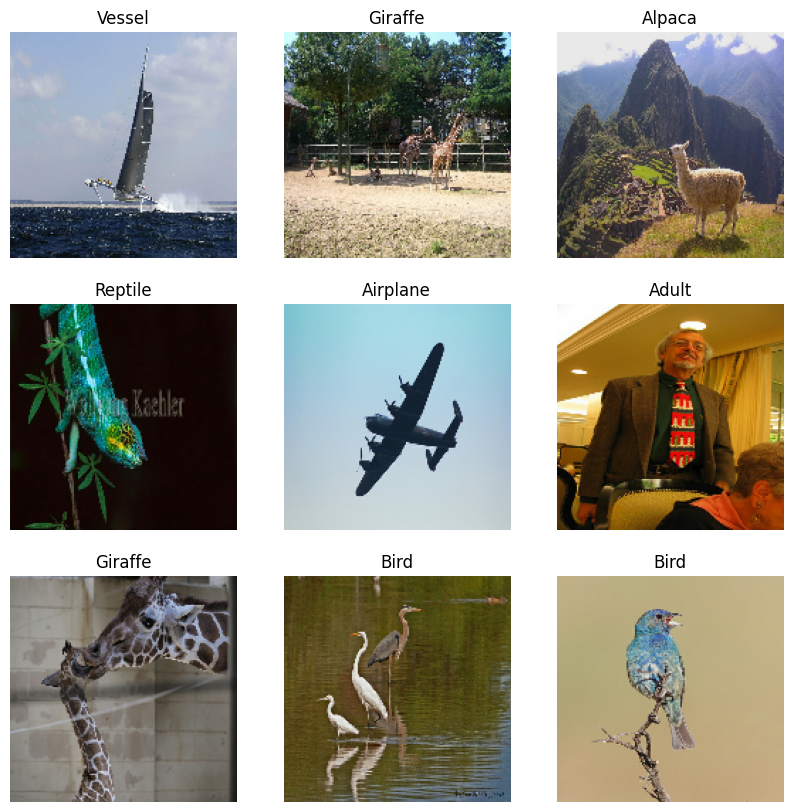

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 12
Number of test batches: 3


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate` or `Model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

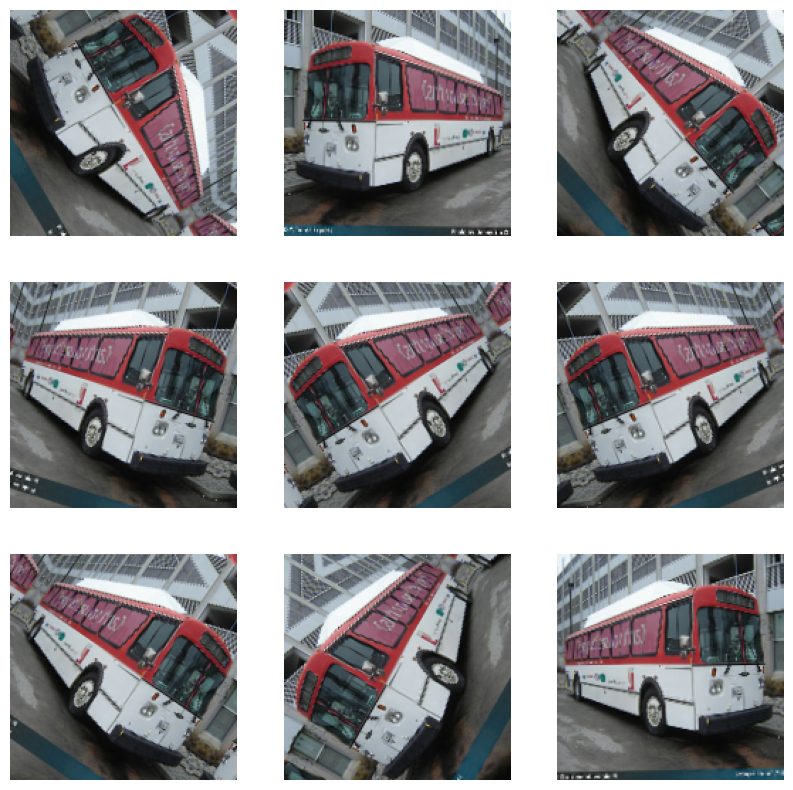

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [14]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [21]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

12/12 [==============================] - 8s 415ms/step - loss: 1.8079 - accuracy: 0.0729


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.81
initial accuracy: 0.07


In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
58/58 [==============================] - 34s 483ms/step - loss: -7.2363 - accuracy: 0.0740 - val_loss: -12.9142 - val_accuracy: 0.0547
Epoch 2/10
58/58 [==============================] - 31s 523ms/step - loss: -24.8281 - accuracy: 0.0615 - val_loss: -26.7293 - val_accuracy: 0.0651
Epoch 3/10
58/58 [==============================] - 29s 488ms/step - loss: -42.2937 - accuracy: 0.0615 - val_loss: -40.9223 - val_accuracy: 0.0547
Epoch 4/10
58/58 [==============================] - 28s 479ms/step - loss: -60.0610 - accuracy: 0.0615 - val_loss: -54.0918 - val_accuracy: 0.0599
Epoch 5/10
58/58 [==============================] - 27s 462ms/step - loss: -76.6852 - accuracy: 0.0615 - val_loss: -68.7953 - val_accuracy: 0.0625
Epoch 6/10
58/58 [==============================] - 37s 639ms/step - loss: -95.0002 - accuracy: 0.0615 - val_loss: -82.9235 - val_accuracy: 0.0651
Epoch 7/10
58/58 [==============================] - 31s 532ms/step - loss: -112.2272 - accuracy: 0.0615 - val_loss: -99

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

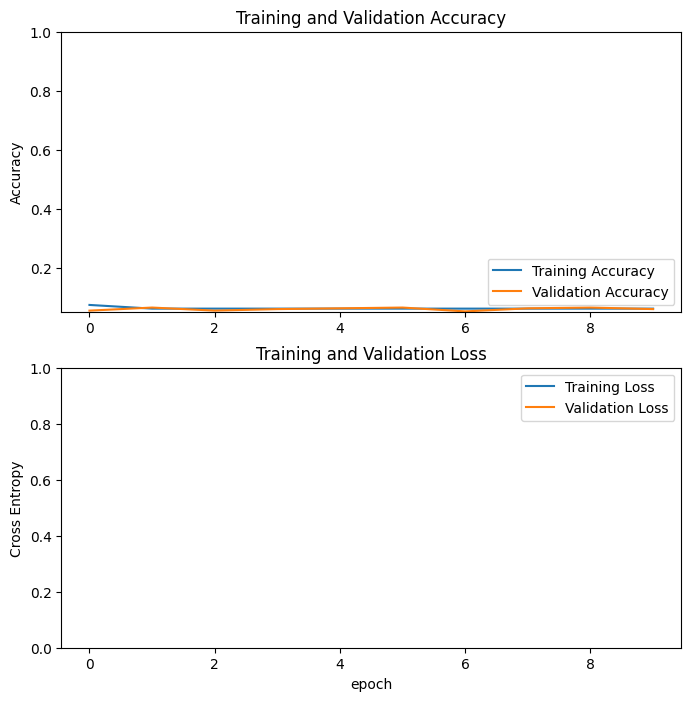

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         


 )                                                               


 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         


 a)                                                              


 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   


 ional)                                                          


 global_average_pooling2d (G  (None, 1280)             0         


 lobalAveragePooling2D)                                          


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2,259,265


Trainable params: 1,862,721


Non-trainable params: 396,544


_________________________________________________________________


In [32]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20



 1/63 [..............................] - ETA: 10:32 - loss: 0.2028 - accuracy: 0.9375


 2/63 [..............................] - ETA: 4s - loss: 0.2057 - accuracy: 0.9375   


 3/63 [>.............................] - ETA: 4s - loss: 0.2116 - accuracy: 0.9167


 4/63 [>.............................] - ETA: 4s - loss: 0.2036 - accuracy: 0.9297


 5/63 [=>............................] - ETA: 4s - loss: 0.1969 - accuracy: 0.9250


 6/63 [=>............................] - ETA: 4s - loss: 0.1834 - accuracy: 0.9323


 7/63 [==>...........................] - ETA: 3s - loss: 0.1695 - accuracy: 0.9375


 8/63 [==>...........................] - ETA: 3s - loss: 0.1793 - accuracy: 0.9297


 9/63 [===>..........................] - ETA: 3s - loss: 0.1745 - accuracy: 0.9306


10/63 [===>..........................] - ETA: 3s - loss: 0.1894 - accuracy: 0.9250


11/63 [====>.........................] - ETA: 3s - loss: 0.1852 - accuracy: 0.9233


12/63 [====>.........................] - ETA: 3s - loss: 0.1795 - accuracy: 0.9245


13/63 [=====>........................] - ETA: 3s - loss: 0.1729 - accuracy: 0.9279


14/63 [=====>........................] - ETA: 3s - loss: 0.1684 - accuracy: 0.9286


15/63 [======>.......................] - ETA: 3s - loss: 0.1739 - accuracy: 0.9271


16/63 [======>.......................] - ETA: 3s - loss: 0.1744 - accuracy: 0.9258


17/63 [=======>......................] - ETA: 3s - loss: 0.1719 - accuracy: 0.9265


18/63 [=======>......................] - ETA: 3s - loss: 0.1654 - accuracy: 0.9306


19/63 [========>.....................] - ETA: 3s - loss: 0.1703 - accuracy: 0.9276


20/63 [========>.....................] - ETA: 2s - loss: 0.1675 - accuracy: 0.9281


21/63 [=========>....................] - ETA: 2s - loss: 0.1662 - accuracy: 0.9271


22/63 [=========>....................] - ETA: 2s - loss: 0.1653 - accuracy: 0.9261


23/63 [=========>....................] - ETA: 2s - loss: 0.1632 - accuracy: 0.9266


24/63 [==========>...................] - ETA: 2s - loss: 0.1586 - accuracy: 0.9297


25/63 [==========>...................] - ETA: 2s - loss: 0.1586 - accuracy: 0.9287


26/63 [===========>..................] - ETA: 2s - loss: 0.1606 - accuracy: 0.9255


27/63 [===========>..................] - ETA: 2s - loss: 0.1595 - accuracy: 0.9259


28/63 [============>.................] - ETA: 2s - loss: 0.1582 - accuracy: 0.9263


29/63 [============>.................] - ETA: 2s - loss: 0.1546 - accuracy: 0.9289


30/63 [=============>................] - ETA: 2s - loss: 0.1529 - accuracy: 0.9302


31/63 [=============>................] - ETA: 2s - loss: 0.1509 - accuracy: 0.9315


32/63 [==============>...............] - ETA: 2s - loss: 0.1555 - accuracy: 0.9297


33/63 [==============>...............] - ETA: 2s - loss: 0.1583 - accuracy: 0.9299


34/63 [===============>..............] - ETA: 1s - loss: 0.1614 - accuracy: 0.9274


35/63 [===============>..............] - ETA: 1s - loss: 0.1595 - accuracy: 0.9295


36/63 [================>.............] - ETA: 1s - loss: 0.1591 - accuracy: 0.9306


37/63 [================>.............] - ETA: 1s - loss: 0.1561 - accuracy: 0.9324


38/63 [=================>............] - ETA: 1s - loss: 0.1564 - accuracy: 0.9326


39/63 [=================>............] - ETA: 1s - loss: 0.1553 - accuracy: 0.9319


40/63 [==================>...........] - ETA: 1s - loss: 0.1536 - accuracy: 0.9336


41/63 [==================>...........] - ETA: 1s - loss: 0.1563 - accuracy: 0.9329


42/63 [===================>..........] - ETA: 1s - loss: 0.1549 - accuracy: 0.9330


43/63 [===================>..........] - ETA: 1s - loss: 0.1540 - accuracy: 0.9339


44/63 [===================>..........] - ETA: 1s - loss: 0.1549 - accuracy: 0.9339


45/63 [====================>.........] - ETA: 1s - loss: 0.1554 - accuracy: 0.9333


46/63 [====================>.........] - ETA: 1s - loss: 0.1538 - accuracy: 0.9348


47/63 [=====================>........] - ETA: 1s - loss: 0.1543 - accuracy: 0.9335


48/63 [=====================>........] - ETA: 1s - loss: 0.1538 - accuracy: 0.9336


49/63 [======================>.......] - ETA: 0s - loss: 0.1514 - accuracy: 0.9349


50/63 [======================>.......] - ETA: 0s - loss: 0.1495 - accuracy: 0.9362


51/63 [=======================>......] - ETA: 0s - loss: 0.1476 - accuracy: 0.9375


52/63 [=======================>......] - ETA: 0s - loss: 0.1464 - accuracy: 0.9375


53/63 [========================>.....] - ETA: 0s - loss: 0.1459 - accuracy: 0.9375


54/63 [========================>.....] - ETA: 0s - loss: 0.1446 - accuracy: 0.9375


55/63 [=========================>....] - ETA: 0s - loss: 0.1439 - accuracy: 0.9381


56/63 [=========================>....] - ETA: 0s - loss: 0.1450 - accuracy: 0.9386


57/63 [==========================>...] - ETA: 0s - loss: 0.1459 - accuracy: 0.9386


58/63 [==========================>...] - ETA: 0s - loss: 0.1447 - accuracy: 0.9391


59/63 [===========================>..] - ETA: 0s - loss: 0.1454 - accuracy: 0.9380


60/63 [===========================>..] - ETA: 0s - loss: 0.1443 - accuracy: 0.9385


61/63 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9385


62/63 [============================>.] - ETA: 0s - loss: 0.1425 - accuracy: 0.9395


63/63 [==============================] - ETA: 0s - loss: 0.1425 - accuracy: 0.9395


63/63 [==============================] - 16s 88ms/step - loss: 0.1425 - accuracy: 0.9395 - val_loss: 0.0548 - val_accuracy: 0.9802


Epoch 11/20



 1/63 [..............................] - ETA: 6s - loss: 0.0297 - accuracy: 1.0000


 2/63 [..............................] - ETA: 4s - loss: 0.0376 - accuracy: 1.0000


 3/63 [>.............................] - ETA: 3s - loss: 0.0669 - accuracy: 0.9688


 4/63 [>.............................] - ETA: 3s - loss: 0.1077 - accuracy: 0.9609


 5/63 [=>............................] - ETA: 3s - loss: 0.1226 - accuracy: 0.9563


 6/63 [=>............................] - ETA: 4s - loss: 0.1295 - accuracy: 0.9531


 7/63 [==>...........................] - ETA: 3s - loss: 0.1451 - accuracy: 0.9464


 8/63 [==>...........................] - ETA: 3s - loss: 0.1296 - accuracy: 0.9531


 9/63 [===>..........................] - ETA: 3s - loss: 0.1280 - accuracy: 0.9444


10/63 [===>..........................] - ETA: 3s - loss: 0.1206 - accuracy: 0.9500


11/63 [====>.........................] - ETA: 3s - loss: 0.1120 - accuracy: 0.9545


12/63 [====>.........................] - ETA: 3s - loss: 0.1114 - accuracy: 0.9531


13/63 [=====>........................] - ETA: 3s - loss: 0.1094 - accuracy: 0.9543


14/63 [=====>........................] - ETA: 3s - loss: 0.1034 - accuracy: 0.9576


15/63 [======>.......................] - ETA: 3s - loss: 0.1043 - accuracy: 0.9583


16/63 [======>.......................] - ETA: 3s - loss: 0.1003 - accuracy: 0.9609


17/63 [=======>......................] - ETA: 3s - loss: 0.1157 - accuracy: 0.9577


18/63 [=======>......................] - ETA: 3s - loss: 0.1188 - accuracy: 0.9566


19/63 [========>.....................] - ETA: 3s - loss: 0.1214 - accuracy: 0.9556


20/63 [========>.....................] - ETA: 2s - loss: 0.1256 - accuracy: 0.9547


21/63 [=========>....................] - ETA: 2s - loss: 0.1304 - accuracy: 0.9524


22/63 [=========>....................] - ETA: 2s - loss: 0.1317 - accuracy: 0.9531


23/63 [=========>....................] - ETA: 2s - loss: 0.1289 - accuracy: 0.9552


24/63 [==========>...................] - ETA: 2s - loss: 0.1321 - accuracy: 0.9531


25/63 [==========>...................] - ETA: 2s - loss: 0.1281 - accuracy: 0.9550


26/63 [===========>..................] - ETA: 2s - loss: 0.1246 - accuracy: 0.9567


27/63 [===========>..................] - ETA: 2s - loss: 0.1273 - accuracy: 0.9537


28/63 [============>.................] - ETA: 2s - loss: 0.1247 - accuracy: 0.9554


29/63 [============>.................] - ETA: 2s - loss: 0.1233 - accuracy: 0.9547


30/63 [=============>................] - ETA: 2s - loss: 0.1209 - accuracy: 0.9552


31/63 [=============>................] - ETA: 2s - loss: 0.1184 - accuracy: 0.9567


32/63 [==============>...............] - ETA: 2s - loss: 0.1180 - accuracy: 0.9570


33/63 [==============>...............] - ETA: 2s - loss: 0.1208 - accuracy: 0.9545


34/63 [===============>..............] - ETA: 2s - loss: 0.1219 - accuracy: 0.9540


35/63 [===============>..............] - ETA: 1s - loss: 0.1221 - accuracy: 0.9545


36/63 [================>.............] - ETA: 1s - loss: 0.1205 - accuracy: 0.9549


37/63 [================>.............] - ETA: 1s - loss: 0.1203 - accuracy: 0.9552


38/63 [=================>............] - ETA: 1s - loss: 0.1200 - accuracy: 0.9548


39/63 [=================>............] - ETA: 1s - loss: 0.1214 - accuracy: 0.9551


40/63 [==================>...........] - ETA: 1s - loss: 0.1260 - accuracy: 0.9539


41/63 [==================>...........] - ETA: 1s - loss: 0.1255 - accuracy: 0.9535


42/63 [===================>..........] - ETA: 1s - loss: 0.1349 - accuracy: 0.9501


43/63 [===================>..........] - ETA: 1s - loss: 0.1327 - accuracy: 0.9513


44/63 [===================>..........] - ETA: 1s - loss: 0.1311 - accuracy: 0.9524


45/63 [====================>.........] - ETA: 1s - loss: 0.1325 - accuracy: 0.9507


46/63 [====================>.........] - ETA: 1s - loss: 0.1352 - accuracy: 0.9497


47/63 [=====================>........] - ETA: 1s - loss: 0.1344 - accuracy: 0.9501


48/63 [=====================>........] - ETA: 1s - loss: 0.1329 - accuracy: 0.9505


49/63 [======================>.......] - ETA: 0s - loss: 0.1306 - accuracy: 0.9515


50/63 [======================>.......] - ETA: 0s - loss: 0.1292 - accuracy: 0.9519


51/63 [=======================>......] - ETA: 0s - loss: 0.1286 - accuracy: 0.9522


52/63 [=======================>......] - ETA: 0s - loss: 0.1276 - accuracy: 0.9525


53/63 [========================>.....] - ETA: 0s - loss: 0.1293 - accuracy: 0.9522


54/63 [========================>.....] - ETA: 0s - loss: 0.1288 - accuracy: 0.9525


55/63 [=========================>....] - ETA: 0s - loss: 0.1303 - accuracy: 0.9517


56/63 [=========================>....] - ETA: 0s - loss: 0.1298 - accuracy: 0.9509


57/63 [==========================>...] - ETA: 0s - loss: 0.1281 - accuracy: 0.9518


58/63 [==========================>...] - ETA: 0s - loss: 0.1261 - accuracy: 0.9526


59/63 [===========================>..] - ETA: 0s - loss: 0.1257 - accuracy: 0.9529


60/63 [===========================>..] - ETA: 0s - loss: 0.1247 - accuracy: 0.9531


61/63 [============================>.] - ETA: 0s - loss: 0.1244 - accuracy: 0.9524


62/63 [============================>.] - ETA: 0s - loss: 0.1230 - accuracy: 0.9531


63/63 [==============================] - 5s 76ms/step - loss: 0.1236 - accuracy: 0.9520 - val_loss: 0.0475 - val_accuracy: 0.9889


Epoch 12/20



 1/63 [..............................] - ETA: 6s - loss: 0.1298 - accuracy: 0.9375


 2/63 [..............................] - ETA: 4s - loss: 0.1126 - accuracy: 0.9531


 3/63 [>.............................] - ETA: 4s - loss: 0.1008 - accuracy: 0.9688


 4/63 [>.............................] - ETA: 4s - loss: 0.0817 - accuracy: 0.9766


 5/63 [=>............................] - ETA: 3s - loss: 0.1034 - accuracy: 0.9625


 6/63 [=>............................] - ETA: 3s - loss: 0.1027 - accuracy: 0.9583


 7/63 [==>...........................] - ETA: 3s - loss: 0.1002 - accuracy: 0.9598


 8/63 [==>...........................] - ETA: 3s - loss: 0.1032 - accuracy: 0.9531


 9/63 [===>..........................] - ETA: 3s - loss: 0.1165 - accuracy: 0.9479


10/63 [===>..........................] - ETA: 3s - loss: 0.1160 - accuracy: 0.9500


11/63 [====>.........................] - ETA: 3s - loss: 0.1132 - accuracy: 0.9517


12/63 [====>.........................] - ETA: 3s - loss: 0.1051 - accuracy: 0.9557


13/63 [=====>........................] - ETA: 3s - loss: 0.1145 - accuracy: 0.9495


14/63 [=====>........................] - ETA: 3s - loss: 0.1160 - accuracy: 0.9509


15/63 [======>.......................] - ETA: 3s - loss: 0.1190 - accuracy: 0.9500


16/63 [======>.......................] - ETA: 3s - loss: 0.1209 - accuracy: 0.9492


17/63 [=======>......................] - ETA: 3s - loss: 0.1158 - accuracy: 0.9522


18/63 [=======>......................] - ETA: 3s - loss: 0.1160 - accuracy: 0.9497


19/63 [========>.....................] - ETA: 2s - loss: 0.1178 - accuracy: 0.9490


20/63 [========>.....................] - ETA: 2s - loss: 0.1154 - accuracy: 0.9484


21/63 [=========>....................] - ETA: 2s - loss: 0.1124 - accuracy: 0.9509


22/63 [=========>....................] - ETA: 2s - loss: 0.1131 - accuracy: 0.9503


23/63 [=========>....................] - ETA: 2s - loss: 0.1131 - accuracy: 0.9511


24/63 [==========>...................] - ETA: 2s - loss: 0.1098 - accuracy: 0.9531


25/63 [==========>...................] - ETA: 2s - loss: 0.1104 - accuracy: 0.9525


26/63 [===========>..................] - ETA: 2s - loss: 0.1105 - accuracy: 0.9519


27/63 [===========>..................] - ETA: 2s - loss: 0.1165 - accuracy: 0.9502


28/63 [============>.................] - ETA: 2s - loss: 0.1151 - accuracy: 0.9509


29/63 [============>.................] - ETA: 2s - loss: 0.1126 - accuracy: 0.9515


30/63 [=============>................] - ETA: 2s - loss: 0.1112 - accuracy: 0.9521


31/63 [=============>................] - ETA: 2s - loss: 0.1082 - accuracy: 0.9536


32/63 [==============>...............] - ETA: 2s - loss: 0.1123 - accuracy: 0.9512


33/63 [==============>...............] - ETA: 2s - loss: 0.1128 - accuracy: 0.9517


34/63 [===============>..............] - ETA: 1s - loss: 0.1120 - accuracy: 0.9522


35/63 [===============>..............] - ETA: 1s - loss: 0.1113 - accuracy: 0.9518


36/63 [================>.............] - ETA: 1s - loss: 0.1137 - accuracy: 0.9497


37/63 [================>.............] - ETA: 1s - loss: 0.1196 - accuracy: 0.9476


38/63 [=================>............] - ETA: 1s - loss: 0.1211 - accuracy: 0.9474


39/63 [=================>............] - ETA: 1s - loss: 0.1196 - accuracy: 0.9479


40/63 [==================>...........] - ETA: 1s - loss: 0.1183 - accuracy: 0.9477


41/63 [==================>...........] - ETA: 1s - loss: 0.1162 - accuracy: 0.9489


42/63 [===================>..........] - ETA: 1s - loss: 0.1157 - accuracy: 0.9494


43/63 [===================>..........] - ETA: 1s - loss: 0.1180 - accuracy: 0.9484


44/63 [===================>..........] - ETA: 1s - loss: 0.1172 - accuracy: 0.9489


45/63 [====================>.........] - ETA: 1s - loss: 0.1155 - accuracy: 0.9500


46/63 [====================>.........] - ETA: 1s - loss: 0.1153 - accuracy: 0.9504


47/63 [=====================>........] - ETA: 1s - loss: 0.1156 - accuracy: 0.9508


48/63 [=====================>........] - ETA: 1s - loss: 0.1144 - accuracy: 0.9518


49/63 [======================>.......] - ETA: 0s - loss: 0.1142 - accuracy: 0.9515


50/63 [======================>.......] - ETA: 0s - loss: 0.1126 - accuracy: 0.9519


51/63 [=======================>......] - ETA: 0s - loss: 0.1114 - accuracy: 0.9528


52/63 [=======================>......] - ETA: 0s - loss: 0.1118 - accuracy: 0.9525


53/63 [========================>.....] - ETA: 0s - loss: 0.1113 - accuracy: 0.9528


54/63 [========================>.....] - ETA: 0s - loss: 0.1097 - accuracy: 0.9537


55/63 [=========================>....] - ETA: 0s - loss: 0.1082 - accuracy: 0.9545


56/63 [=========================>....] - ETA: 0s - loss: 0.1067 - accuracy: 0.9554


57/63 [==========================>...] - ETA: 0s - loss: 0.1050 - accuracy: 0.9561


58/63 [==========================>...] - ETA: 0s - loss: 0.1047 - accuracy: 0.9564


59/63 [===========================>..] - ETA: 0s - loss: 0.1084 - accuracy: 0.9550


60/63 [===========================>..] - ETA: 0s - loss: 0.1083 - accuracy: 0.9547


61/63 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.9549


62/63 [============================>.] - ETA: 0s - loss: 0.1080 - accuracy: 0.9546


63/63 [==============================] - 5s 75ms/step - loss: 0.1099 - accuracy: 0.9545 - val_loss: 0.0499 - val_accuracy: 0.9876


Epoch 13/20



 1/63 [..............................] - ETA: 6s - loss: 0.0241 - accuracy: 1.0000


 2/63 [..............................] - ETA: 4s - loss: 0.0261 - accuracy: 1.0000


 3/63 [>.............................] - ETA: 3s - loss: 0.0550 - accuracy: 0.9792


 4/63 [>.............................] - ETA: 3s - loss: 0.0485 - accuracy: 0.9844


 5/63 [=>............................] - ETA: 3s - loss: 0.0547 - accuracy: 0.9750


 6/63 [=>............................] - ETA: 3s - loss: 0.0737 - accuracy: 0.9688


 7/63 [==>...........................] - ETA: 3s - loss: 0.0686 - accuracy: 0.9732


 8/63 [==>...........................] - ETA: 3s - loss: 0.0677 - accuracy: 0.9688


 9/63 [===>..........................] - ETA: 3s - loss: 0.0650 - accuracy: 0.9688


10/63 [===>..........................] - ETA: 3s - loss: 0.0635 - accuracy: 0.9719


11/63 [====>.........................] - ETA: 3s - loss: 0.0615 - accuracy: 0.9744


12/63 [====>.........................] - ETA: 3s - loss: 0.0667 - accuracy: 0.9688


13/63 [=====>........................] - ETA: 3s - loss: 0.0628 - accuracy: 0.9712


14/63 [=====>........................] - ETA: 3s - loss: 0.0598 - accuracy: 0.9732


15/63 [======>.......................] - ETA: 3s - loss: 0.0671 - accuracy: 0.9708


16/63 [======>.......................] - ETA: 3s - loss: 0.0693 - accuracy: 0.9688


17/63 [=======>......................] - ETA: 3s - loss: 0.0681 - accuracy: 0.9706


18/63 [=======>......................] - ETA: 2s - loss: 0.0729 - accuracy: 0.9705


19/63 [========>.....................] - ETA: 2s - loss: 0.0741 - accuracy: 0.9688


20/63 [========>.....................] - ETA: 2s - loss: 0.0741 - accuracy: 0.9688


21/63 [=========>....................] - ETA: 2s - loss: 0.0718 - accuracy: 0.9702


22/63 [=========>....................] - ETA: 2s - loss: 0.0788 - accuracy: 0.9688


23/63 [=========>....................] - ETA: 2s - loss: 0.0791 - accuracy: 0.9701


24/63 [==========>...................] - ETA: 2s - loss: 0.0821 - accuracy: 0.9688


25/63 [==========>...................] - ETA: 2s - loss: 0.0848 - accuracy: 0.9675


26/63 [===========>..................] - ETA: 2s - loss: 0.0826 - accuracy: 0.9688


27/63 [===========>..................] - ETA: 2s - loss: 0.0818 - accuracy: 0.9688


28/63 [============>.................] - ETA: 2s - loss: 0.0815 - accuracy: 0.9688


29/63 [============>.................] - ETA: 2s - loss: 0.0836 - accuracy: 0.9677


30/63 [=============>................] - ETA: 2s - loss: 0.0833 - accuracy: 0.9667


31/63 [=============>................] - ETA: 2s - loss: 0.0821 - accuracy: 0.9667


32/63 [==============>...............] - ETA: 2s - loss: 0.0816 - accuracy: 0.9658


33/63 [==============>...............] - ETA: 1s - loss: 0.0884 - accuracy: 0.9621


34/63 [===============>..............] - ETA: 1s - loss: 0.0879 - accuracy: 0.9623


35/63 [===============>..............] - ETA: 1s - loss: 0.0857 - accuracy: 0.9634


36/63 [================>.............] - ETA: 1s - loss: 0.0859 - accuracy: 0.9618


37/63 [================>.............] - ETA: 1s - loss: 0.0880 - accuracy: 0.9603


38/63 [=================>............] - ETA: 1s - loss: 0.0874 - accuracy: 0.9613


39/63 [=================>............] - ETA: 1s - loss: 0.0862 - accuracy: 0.9623


40/63 [==================>...........] - ETA: 1s - loss: 0.0853 - accuracy: 0.9625


41/63 [==================>...........] - ETA: 1s - loss: 0.0849 - accuracy: 0.9627


42/63 [===================>..........] - ETA: 1s - loss: 0.0872 - accuracy: 0.9621


43/63 [===================>..........] - ETA: 1s - loss: 0.0866 - accuracy: 0.9622


44/63 [===================>..........] - ETA: 1s - loss: 0.0878 - accuracy: 0.9616


45/63 [====================>.........] - ETA: 1s - loss: 0.0864 - accuracy: 0.9625


46/63 [====================>.........] - ETA: 1s - loss: 0.0857 - accuracy: 0.9633


47/63 [=====================>........] - ETA: 1s - loss: 0.0849 - accuracy: 0.9641


48/63 [=====================>........] - ETA: 1s - loss: 0.0839 - accuracy: 0.9648


49/63 [======================>.......] - ETA: 0s - loss: 0.0826 - accuracy: 0.9656


50/63 [======================>.......] - ETA: 0s - loss: 0.0850 - accuracy: 0.9638


51/63 [=======================>......] - ETA: 0s - loss: 0.0837 - accuracy: 0.9645


52/63 [=======================>......] - ETA: 0s - loss: 0.0822 - accuracy: 0.9651


53/63 [========================>.....] - ETA: 0s - loss: 0.0816 - accuracy: 0.9652


54/63 [========================>.....] - ETA: 0s - loss: 0.0821 - accuracy: 0.9653


55/63 [=========================>....] - ETA: 0s - loss: 0.0809 - accuracy: 0.9659


56/63 [=========================>....] - ETA: 0s - loss: 0.0800 - accuracy: 0.9660


57/63 [==========================>...] - ETA: 0s - loss: 0.0801 - accuracy: 0.9655


58/63 [==========================>...] - ETA: 0s - loss: 0.0858 - accuracy: 0.9639


59/63 [===========================>..] - ETA: 0s - loss: 0.0877 - accuracy: 0.9635


60/63 [===========================>..] - ETA: 0s - loss: 0.0870 - accuracy: 0.9635


61/63 [============================>.] - ETA: 0s - loss: 0.0863 - accuracy: 0.9641


62/63 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9637


63/63 [==============================] - 5s 75ms/step - loss: 0.0882 - accuracy: 0.9630 - val_loss: 0.0538 - val_accuracy: 0.9790


Epoch 14/20



 1/63 [..............................] - ETA: 6s - loss: 0.1663 - accuracy: 0.9375


 2/63 [..............................] - ETA: 3s - loss: 0.1128 - accuracy: 0.9531


 3/63 [>.............................] - ETA: 4s - loss: 0.1421 - accuracy: 0.9479


 4/63 [>.............................] - ETA: 4s - loss: 0.1241 - accuracy: 0.9531


 5/63 [=>............................] - ETA: 4s - loss: 0.1366 - accuracy: 0.9438


 6/63 [=>............................] - ETA: 3s - loss: 0.1467 - accuracy: 0.9427


 7/63 [==>...........................] - ETA: 3s - loss: 0.1421 - accuracy: 0.9464


 8/63 [==>...........................] - ETA: 3s - loss: 0.1551 - accuracy: 0.9453


 9/63 [===>..........................] - ETA: 3s - loss: 0.1441 - accuracy: 0.9479


10/63 [===>..........................] - ETA: 3s - loss: 0.1384 - accuracy: 0.9500


11/63 [====>.........................] - ETA: 3s - loss: 0.1288 - accuracy: 0.9545


12/63 [====>.........................] - ETA: 3s - loss: 0.1217 - accuracy: 0.9557


13/63 [=====>........................] - ETA: 3s - loss: 0.1275 - accuracy: 0.9519


14/63 [=====>........................] - ETA: 3s - loss: 0.1336 - accuracy: 0.9531


15/63 [======>.......................] - ETA: 3s - loss: 0.1343 - accuracy: 0.9479


16/63 [======>.......................] - ETA: 3s - loss: 0.1274 - accuracy: 0.9512


17/63 [=======>......................] - ETA: 3s - loss: 0.1219 - accuracy: 0.9540


18/63 [=======>......................] - ETA: 3s - loss: 0.1172 - accuracy: 0.9566


19/63 [========>.....................] - ETA: 3s - loss: 0.1121 - accuracy: 0.9589


20/63 [========>.....................] - ETA: 3s - loss: 0.1088 - accuracy: 0.9594


21/63 [=========>....................] - ETA: 2s - loss: 0.1049 - accuracy: 0.9613


22/63 [=========>....................] - ETA: 2s - loss: 0.1042 - accuracy: 0.9616


23/63 [=========>....................] - ETA: 2s - loss: 0.1011 - accuracy: 0.9620


24/63 [==========>...................] - ETA: 2s - loss: 0.0978 - accuracy: 0.9635


25/63 [==========>...................] - ETA: 2s - loss: 0.0944 - accuracy: 0.9650


26/63 [===========>..................] - ETA: 2s - loss: 0.0922 - accuracy: 0.9663


27/63 [===========>..................] - ETA: 2s - loss: 0.0901 - accuracy: 0.9664


28/63 [============>.................] - ETA: 2s - loss: 0.0888 - accuracy: 0.9676


29/63 [============>.................] - ETA: 2s - loss: 0.0865 - accuracy: 0.9688


30/63 [=============>................] - ETA: 2s - loss: 0.0841 - accuracy: 0.9698


31/63 [=============>................] - ETA: 2s - loss: 0.0862 - accuracy: 0.9688


32/63 [==============>...............] - ETA: 2s - loss: 0.0947 - accuracy: 0.9668


33/63 [==============>...............] - ETA: 2s - loss: 0.0937 - accuracy: 0.9659


34/63 [===============>..............] - ETA: 2s - loss: 0.0939 - accuracy: 0.9660


35/63 [===============>..............] - ETA: 1s - loss: 0.0950 - accuracy: 0.9643


36/63 [================>.............] - ETA: 1s - loss: 0.0939 - accuracy: 0.9644


37/63 [================>.............] - ETA: 1s - loss: 0.0965 - accuracy: 0.9637


38/63 [=================>............] - ETA: 1s - loss: 0.0970 - accuracy: 0.9638


39/63 [=================>............] - ETA: 1s - loss: 0.0964 - accuracy: 0.9631


40/63 [==================>...........] - ETA: 1s - loss: 0.0957 - accuracy: 0.9633


41/63 [==================>...........] - ETA: 1s - loss: 0.0972 - accuracy: 0.9619


42/63 [===================>..........] - ETA: 1s - loss: 0.0957 - accuracy: 0.9628


43/63 [===================>..........] - ETA: 1s - loss: 0.0940 - accuracy: 0.9637


44/63 [===================>..........] - ETA: 1s - loss: 0.0940 - accuracy: 0.9624


45/63 [====================>.........] - ETA: 1s - loss: 0.0955 - accuracy: 0.9618


46/63 [====================>.........] - ETA: 1s - loss: 0.0958 - accuracy: 0.9620


47/63 [=====================>........] - ETA: 1s - loss: 0.0962 - accuracy: 0.9621


48/63 [=====================>........] - ETA: 1s - loss: 0.0973 - accuracy: 0.9616


49/63 [======================>.......] - ETA: 0s - loss: 0.0981 - accuracy: 0.9605


50/63 [======================>.......] - ETA: 0s - loss: 0.0989 - accuracy: 0.9594


51/63 [=======================>......] - ETA: 0s - loss: 0.0990 - accuracy: 0.9589


52/63 [=======================>......] - ETA: 0s - loss: 0.0979 - accuracy: 0.9597


53/63 [========================>.....] - ETA: 0s - loss: 0.0963 - accuracy: 0.9605


54/63 [========================>.....] - ETA: 0s - loss: 0.0961 - accuracy: 0.9601


55/63 [=========================>....] - ETA: 0s - loss: 0.0958 - accuracy: 0.9602


56/63 [=========================>....] - ETA: 0s - loss: 0.0951 - accuracy: 0.9604


57/63 [==========================>...] - ETA: 0s - loss: 0.0947 - accuracy: 0.9605


58/63 [==========================>...] - ETA: 0s - loss: 0.0945 - accuracy: 0.9607


59/63 [===========================>..] - ETA: 0s - loss: 0.0947 - accuracy: 0.9608


60/63 [===========================>..] - ETA: 0s - loss: 0.0942 - accuracy: 0.9609


61/63 [============================>.] - ETA: 0s - loss: 0.0951 - accuracy: 0.9606


62/63 [============================>.] - ETA: 0s - loss: 0.0969 - accuracy: 0.9592


63/63 [==============================] - 5s 77ms/step - loss: 0.0966 - accuracy: 0.9595 - val_loss: 0.0457 - val_accuracy: 0.9827


Epoch 15/20



 1/63 [..............................] - ETA: 6s - loss: 0.0508 - accuracy: 1.0000


 2/63 [..............................] - ETA: 3s - loss: 0.0838 - accuracy: 0.9844


 3/63 [>.............................] - ETA: 3s - loss: 0.1150 - accuracy: 0.9479


 4/63 [>.............................] - ETA: 3s - loss: 0.0904 - accuracy: 0.9609


 5/63 [=>............................] - ETA: 3s - loss: 0.0795 - accuracy: 0.9688


 6/63 [=>............................] - ETA: 3s - loss: 0.0796 - accuracy: 0.9635


 7/63 [==>...........................] - ETA: 3s - loss: 0.0888 - accuracy: 0.9554


 8/63 [==>...........................] - ETA: 3s - loss: 0.0814 - accuracy: 0.9609


 9/63 [===>..........................] - ETA: 3s - loss: 0.0746 - accuracy: 0.9653


10/63 [===>..........................] - ETA: 3s - loss: 0.0757 - accuracy: 0.9625


11/63 [====>.........................] - ETA: 3s - loss: 0.0770 - accuracy: 0.9631


12/63 [====>.........................] - ETA: 3s - loss: 0.0718 - accuracy: 0.9661


13/63 [=====>........................] - ETA: 3s - loss: 0.0715 - accuracy: 0.9663


14/63 [=====>........................] - ETA: 3s - loss: 0.0747 - accuracy: 0.9665


15/63 [======>.......................] - ETA: 3s - loss: 0.0729 - accuracy: 0.9688


16/63 [======>.......................] - ETA: 3s - loss: 0.0763 - accuracy: 0.9688


17/63 [=======>......................] - ETA: 3s - loss: 0.0825 - accuracy: 0.9651


18/63 [=======>......................] - ETA: 2s - loss: 0.0790 - accuracy: 0.9670


19/63 [========>.....................] - ETA: 2s - loss: 0.0830 - accuracy: 0.9671


20/63 [========>.....................] - ETA: 2s - loss: 0.0840 - accuracy: 0.9672


21/63 [=========>....................] - ETA: 2s - loss: 0.0809 - accuracy: 0.9688


22/63 [=========>....................] - ETA: 2s - loss: 0.0806 - accuracy: 0.9688


23/63 [=========>....................] - ETA: 2s - loss: 0.0774 - accuracy: 0.9701


24/63 [==========>...................] - ETA: 2s - loss: 0.0766 - accuracy: 0.9701


25/63 [==========>...................] - ETA: 2s - loss: 0.0740 - accuracy: 0.9712


26/63 [===========>..................] - ETA: 2s - loss: 0.0739 - accuracy: 0.9712


27/63 [===========>..................] - ETA: 2s - loss: 0.0748 - accuracy: 0.9711


28/63 [============>.................] - ETA: 2s - loss: 0.0735 - accuracy: 0.9721


29/63 [============>.................] - ETA: 2s - loss: 0.0725 - accuracy: 0.9709


30/63 [=============>................] - ETA: 2s - loss: 0.0723 - accuracy: 0.9698


31/63 [=============>................] - ETA: 2s - loss: 0.0792 - accuracy: 0.9698


32/63 [==============>...............] - ETA: 2s - loss: 0.0783 - accuracy: 0.9707


33/63 [==============>...............] - ETA: 1s - loss: 0.0765 - accuracy: 0.9716


34/63 [===============>..............] - ETA: 1s - loss: 0.0750 - accuracy: 0.9724


35/63 [===============>..............] - ETA: 1s - loss: 0.0756 - accuracy: 0.9705


36/63 [================>.............] - ETA: 1s - loss: 0.0761 - accuracy: 0.9696


37/63 [================>.............] - ETA: 1s - loss: 0.0774 - accuracy: 0.9696


38/63 [=================>............] - ETA: 1s - loss: 0.0768 - accuracy: 0.9696


39/63 [=================>............] - ETA: 1s - loss: 0.0755 - accuracy: 0.9704


40/63 [==================>...........] - ETA: 1s - loss: 0.0740 - accuracy: 0.9711


41/63 [==================>...........] - ETA: 1s - loss: 0.0764 - accuracy: 0.9703


42/63 [===================>..........] - ETA: 1s - loss: 0.0752 - accuracy: 0.9710


43/63 [===================>..........] - ETA: 1s - loss: 0.0758 - accuracy: 0.9709


44/63 [===================>..........] - ETA: 1s - loss: 0.0766 - accuracy: 0.9702


45/63 [====================>.........] - ETA: 1s - loss: 0.0760 - accuracy: 0.9708


46/63 [====================>.........] - ETA: 1s - loss: 0.0763 - accuracy: 0.9701


47/63 [=====================>........] - ETA: 1s - loss: 0.0764 - accuracy: 0.9701


48/63 [=====================>........] - ETA: 0s - loss: 0.0759 - accuracy: 0.9707


49/63 [======================>.......] - ETA: 0s - loss: 0.0747 - accuracy: 0.9713


50/63 [======================>.......] - ETA: 0s - loss: 0.0747 - accuracy: 0.9712


51/63 [=======================>......] - ETA: 0s - loss: 0.0751 - accuracy: 0.9706


52/63 [=======================>......] - ETA: 0s - loss: 0.0788 - accuracy: 0.9688


53/63 [========================>.....] - ETA: 0s - loss: 0.0780 - accuracy: 0.9688


54/63 [========================>.....] - ETA: 0s - loss: 0.0772 - accuracy: 0.9693


55/63 [=========================>....] - ETA: 0s - loss: 0.0777 - accuracy: 0.9693


56/63 [=========================>....] - ETA: 0s - loss: 0.0766 - accuracy: 0.9699


57/63 [==========================>...] - ETA: 0s - loss: 0.0765 - accuracy: 0.9704


58/63 [==========================>...] - ETA: 0s - loss: 0.0762 - accuracy: 0.9704


59/63 [===========================>..] - ETA: 0s - loss: 0.0760 - accuracy: 0.9703


60/63 [===========================>..] - ETA: 0s - loss: 0.0752 - accuracy: 0.9708


61/63 [============================>.] - ETA: 0s - loss: 0.0772 - accuracy: 0.9703


62/63 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9708


63/63 [==============================] - 5s 74ms/step - loss: 0.0760 - accuracy: 0.9710 - val_loss: 0.0415 - val_accuracy: 0.9864


Epoch 16/20



 1/63 [..............................] - ETA: 6s - loss: 0.0323 - accuracy: 1.0000


 2/63 [..............................] - ETA: 4s - loss: 0.0213 - accuracy: 1.0000


 3/63 [>.............................] - ETA: 4s - loss: 0.0372 - accuracy: 0.9896


 4/63 [>.............................] - ETA: 4s - loss: 0.0617 - accuracy: 0.9766


 5/63 [=>............................] - ETA: 3s - loss: 0.0766 - accuracy: 0.9750


 6/63 [=>............................] - ETA: 3s - loss: 0.0655 - accuracy: 0.9792


 7/63 [==>...........................] - ETA: 3s - loss: 0.0844 - accuracy: 0.9688


 8/63 [==>...........................] - ETA: 3s - loss: 0.0767 - accuracy: 0.9727


 9/63 [===>..........................] - ETA: 3s - loss: 0.0719 - accuracy: 0.9757


10/63 [===>..........................] - ETA: 3s - loss: 0.1003 - accuracy: 0.9625


11/63 [====>.........................] - ETA: 3s - loss: 0.0941 - accuracy: 0.9659


12/63 [====>.........................] - ETA: 3s - loss: 0.0909 - accuracy: 0.9661


13/63 [=====>........................] - ETA: 3s - loss: 0.0913 - accuracy: 0.9663


14/63 [=====>........................] - ETA: 3s - loss: 0.0894 - accuracy: 0.9665


15/63 [======>.......................] - ETA: 3s - loss: 0.0946 - accuracy: 0.9646


16/63 [======>.......................] - ETA: 3s - loss: 0.0932 - accuracy: 0.9648


17/63 [=======>......................] - ETA: 3s - loss: 0.0901 - accuracy: 0.9651


18/63 [=======>......................] - ETA: 3s - loss: 0.0892 - accuracy: 0.9635


19/63 [========>.....................] - ETA: 3s - loss: 0.0857 - accuracy: 0.9655


20/63 [========>.....................] - ETA: 2s - loss: 0.0846 - accuracy: 0.9656


21/63 [=========>....................] - ETA: 2s - loss: 0.0811 - accuracy: 0.9673


22/63 [=========>....................] - ETA: 2s - loss: 0.0828 - accuracy: 0.9645


23/63 [=========>....................] - ETA: 2s - loss: 0.0812 - accuracy: 0.9647


24/63 [==========>...................] - ETA: 2s - loss: 0.0805 - accuracy: 0.9648


25/63 [==========>...................] - ETA: 2s - loss: 0.0792 - accuracy: 0.9650


26/63 [===========>..................] - ETA: 2s - loss: 0.0806 - accuracy: 0.9639


27/63 [===========>..................] - ETA: 2s - loss: 0.0828 - accuracy: 0.9630


28/63 [============>.................] - ETA: 2s - loss: 0.0812 - accuracy: 0.9643


29/63 [============>.................] - ETA: 2s - loss: 0.0808 - accuracy: 0.9644


30/63 [=============>................] - ETA: 2s - loss: 0.0784 - accuracy: 0.9656


31/63 [=============>................] - ETA: 2s - loss: 0.0778 - accuracy: 0.9657


32/63 [==============>...............] - ETA: 2s - loss: 0.0758 - accuracy: 0.9668


33/63 [==============>...............] - ETA: 2s - loss: 0.0787 - accuracy: 0.9659


34/63 [===============>..............] - ETA: 1s - loss: 0.0780 - accuracy: 0.9651


35/63 [===============>..............] - ETA: 1s - loss: 0.0776 - accuracy: 0.9652


36/63 [================>.............] - ETA: 1s - loss: 0.0778 - accuracy: 0.9644


37/63 [================>.............] - ETA: 1s - loss: 0.0804 - accuracy: 0.9637


38/63 [=================>............] - ETA: 1s - loss: 0.0826 - accuracy: 0.9630


39/63 [=================>............] - ETA: 1s - loss: 0.0835 - accuracy: 0.9631


40/63 [==================>...........] - ETA: 1s - loss: 0.0847 - accuracy: 0.9625


41/63 [==================>...........] - ETA: 1s - loss: 0.0836 - accuracy: 0.9627


42/63 [===================>..........] - ETA: 1s - loss: 0.0838 - accuracy: 0.9628


43/63 [===================>..........] - ETA: 1s - loss: 0.0880 - accuracy: 0.9615


44/63 [===================>..........] - ETA: 1s - loss: 0.0890 - accuracy: 0.9616


45/63 [====================>.........] - ETA: 1s - loss: 0.0885 - accuracy: 0.9618


46/63 [====================>.........] - ETA: 1s - loss: 0.0910 - accuracy: 0.9613


47/63 [=====================>........] - ETA: 1s - loss: 0.0913 - accuracy: 0.9608


48/63 [=====================>........] - ETA: 1s - loss: 0.0898 - accuracy: 0.9616


49/63 [======================>.......] - ETA: 0s - loss: 0.0883 - accuracy: 0.9624


50/63 [======================>.......] - ETA: 0s - loss: 0.0882 - accuracy: 0.9625


51/63 [=======================>......] - ETA: 0s - loss: 0.0879 - accuracy: 0.9626


52/63 [=======================>......] - ETA: 0s - loss: 0.0874 - accuracy: 0.9633


53/63 [========================>.....] - ETA: 0s - loss: 0.0875 - accuracy: 0.9634


54/63 [========================>.....] - ETA: 0s - loss: 0.0868 - accuracy: 0.9635


55/63 [=========================>....] - ETA: 0s - loss: 0.0870 - accuracy: 0.9631


56/63 [=========================>....] - ETA: 0s - loss: 0.0858 - accuracy: 0.9637


57/63 [==========================>...] - ETA: 0s - loss: 0.0872 - accuracy: 0.9627


58/63 [==========================>...] - ETA: 0s - loss: 0.0861 - accuracy: 0.9634


59/63 [===========================>..] - ETA: 0s - loss: 0.0847 - accuracy: 0.9640


60/63 [===========================>..] - ETA: 0s - loss: 0.0835 - accuracy: 0.9646


61/63 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9641


62/63 [============================>.] - ETA: 0s - loss: 0.0858 - accuracy: 0.9637


63/63 [==============================] - 5s 75ms/step - loss: 0.0851 - accuracy: 0.9640 - val_loss: 0.0564 - val_accuracy: 0.9765


Epoch 17/20



 1/63 [..............................] - ETA: 6s - loss: 0.0304 - accuracy: 1.0000


 2/63 [..............................] - ETA: 4s - loss: 0.0635 - accuracy: 0.9844


 3/63 [>.............................] - ETA: 4s - loss: 0.0448 - accuracy: 0.9896


 4/63 [>.............................] - ETA: 3s - loss: 0.0378 - accuracy: 0.9922


 5/63 [=>............................] - ETA: 3s - loss: 0.0710 - accuracy: 0.9875


 6/63 [=>............................] - ETA: 3s - loss: 0.0755 - accuracy: 0.9844


 7/63 [==>...........................] - ETA: 3s - loss: 0.0982 - accuracy: 0.9732


 8/63 [==>...........................] - ETA: 3s - loss: 0.0928 - accuracy: 0.9766


 9/63 [===>..........................] - ETA: 3s - loss: 0.0876 - accuracy: 0.9792


10/63 [===>..........................] - ETA: 3s - loss: 0.0811 - accuracy: 0.9812


11/63 [====>.........................] - ETA: 3s - loss: 0.0781 - accuracy: 0.9830


12/63 [====>.........................] - ETA: 3s - loss: 0.0772 - accuracy: 0.9818


13/63 [=====>........................] - ETA: 3s - loss: 0.0796 - accuracy: 0.9808


14/63 [=====>........................] - ETA: 3s - loss: 0.0758 - accuracy: 0.9821


15/63 [======>.......................] - ETA: 3s - loss: 0.0785 - accuracy: 0.9812


16/63 [======>.......................] - ETA: 3s - loss: 0.0759 - accuracy: 0.9824


17/63 [=======>......................] - ETA: 3s - loss: 0.0722 - accuracy: 0.9835


18/63 [=======>......................] - ETA: 2s - loss: 0.0706 - accuracy: 0.9826


19/63 [========>.....................] - ETA: 2s - loss: 0.0692 - accuracy: 0.9836


20/63 [========>.....................] - ETA: 2s - loss: 0.0697 - accuracy: 0.9828


21/63 [=========>....................] - ETA: 2s - loss: 0.0725 - accuracy: 0.9821


22/63 [=========>....................] - ETA: 2s - loss: 0.0717 - accuracy: 0.9830


23/63 [=========>....................] - ETA: 2s - loss: 0.0715 - accuracy: 0.9823


24/63 [==========>...................] - ETA: 2s - loss: 0.0691 - accuracy: 0.9831


25/63 [==========>...................] - ETA: 2s - loss: 0.0689 - accuracy: 0.9825


26/63 [===========>..................] - ETA: 2s - loss: 0.0686 - accuracy: 0.9820


27/63 [===========>..................] - ETA: 2s - loss: 0.0667 - accuracy: 0.9826


28/63 [============>.................] - ETA: 2s - loss: 0.0677 - accuracy: 0.9821


29/63 [============>.................] - ETA: 2s - loss: 0.0683 - accuracy: 0.9806


30/63 [=============>................] - ETA: 2s - loss: 0.0679 - accuracy: 0.9802


31/63 [=============>................] - ETA: 2s - loss: 0.0659 - accuracy: 0.9808


32/63 [==============>...............] - ETA: 2s - loss: 0.0686 - accuracy: 0.9795


33/63 [==============>...............] - ETA: 1s - loss: 0.0681 - accuracy: 0.9792


34/63 [===============>..............] - ETA: 1s - loss: 0.0689 - accuracy: 0.9789


35/63 [===============>..............] - ETA: 1s - loss: 0.0681 - accuracy: 0.9786


36/63 [================>.............] - ETA: 1s - loss: 0.0676 - accuracy: 0.9783


37/63 [================>.............] - ETA: 1s - loss: 0.0671 - accuracy: 0.9780


38/63 [=================>............] - ETA: 1s - loss: 0.0664 - accuracy: 0.9778


39/63 [=================>............] - ETA: 1s - loss: 0.0674 - accuracy: 0.9768


40/63 [==================>...........] - ETA: 1s - loss: 0.0704 - accuracy: 0.9758


41/63 [==================>...........] - ETA: 1s - loss: 0.0716 - accuracy: 0.9756


42/63 [===================>..........] - ETA: 1s - loss: 0.0778 - accuracy: 0.9740


43/63 [===================>..........] - ETA: 1s - loss: 0.0768 - accuracy: 0.9746


44/63 [===================>..........] - ETA: 1s - loss: 0.0754 - accuracy: 0.9751


45/63 [====================>.........] - ETA: 1s - loss: 0.0750 - accuracy: 0.9750


46/63 [====================>.........] - ETA: 1s - loss: 0.0756 - accuracy: 0.9749


47/63 [=====================>........] - ETA: 1s - loss: 0.0773 - accuracy: 0.9747


48/63 [=====================>........] - ETA: 0s - loss: 0.0763 - accuracy: 0.9746


49/63 [======================>.......] - ETA: 0s - loss: 0.0756 - accuracy: 0.9745


50/63 [======================>.......] - ETA: 0s - loss: 0.0751 - accuracy: 0.9750


51/63 [=======================>......] - ETA: 0s - loss: 0.0760 - accuracy: 0.9743


52/63 [=======================>......] - ETA: 0s - loss: 0.0759 - accuracy: 0.9742


53/63 [========================>.....] - ETA: 0s - loss: 0.0747 - accuracy: 0.9746


54/63 [========================>.....] - ETA: 0s - loss: 0.0747 - accuracy: 0.9745


55/63 [=========================>....] - ETA: 0s - loss: 0.0735 - accuracy: 0.9750


56/63 [=========================>....] - ETA: 0s - loss: 0.0735 - accuracy: 0.9749


57/63 [==========================>...] - ETA: 0s - loss: 0.0738 - accuracy: 0.9737


58/63 [==========================>...] - ETA: 0s - loss: 0.0729 - accuracy: 0.9741


59/63 [===========================>..] - ETA: 0s - loss: 0.0732 - accuracy: 0.9740


60/63 [===========================>..] - ETA: 0s - loss: 0.0739 - accuracy: 0.9740


61/63 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9744


62/63 [============================>.] - ETA: 0s - loss: 0.0722 - accuracy: 0.9743


63/63 [==============================] - 5s 73ms/step - loss: 0.0721 - accuracy: 0.9740 - val_loss: 0.0537 - val_accuracy: 0.9839


Epoch 18/20



 1/63 [..............................] - ETA: 6s - loss: 0.1510 - accuracy: 0.9688


 2/63 [..............................] - ETA: 4s - loss: 0.1032 - accuracy: 0.9688


 3/63 [>.............................] - ETA: 4s - loss: 0.1179 - accuracy: 0.9583


 4/63 [>.............................] - ETA: 3s - loss: 0.1772 - accuracy: 0.9375


 5/63 [=>............................] - ETA: 3s - loss: 0.1491 - accuracy: 0.9500


 6/63 [=>............................] - ETA: 3s - loss: 0.1467 - accuracy: 0.9479


 7/63 [==>...........................] - ETA: 3s - loss: 0.1433 - accuracy: 0.9509


 8/63 [==>...........................] - ETA: 3s - loss: 0.1330 - accuracy: 0.9531


 9/63 [===>..........................] - ETA: 3s - loss: 0.1257 - accuracy: 0.9583


10/63 [===>..........................] - ETA: 3s - loss: 0.1260 - accuracy: 0.9563


11/63 [====>.........................] - ETA: 3s - loss: 0.1201 - accuracy: 0.9574


12/63 [====>.........................] - ETA: 3s - loss: 0.1185 - accuracy: 0.9583


13/63 [=====>........................] - ETA: 3s - loss: 0.1139 - accuracy: 0.9615


14/63 [=====>........................] - ETA: 3s - loss: 0.1089 - accuracy: 0.9621


15/63 [======>.......................] - ETA: 3s - loss: 0.1025 - accuracy: 0.9646


16/63 [======>.......................] - ETA: 3s - loss: 0.1092 - accuracy: 0.9590


17/63 [=======>......................] - ETA: 2s - loss: 0.1033 - accuracy: 0.9614


18/63 [=======>......................] - ETA: 2s - loss: 0.1045 - accuracy: 0.9601


19/63 [========>.....................] - ETA: 2s - loss: 0.1002 - accuracy: 0.9622


20/63 [========>.....................] - ETA: 2s - loss: 0.0958 - accuracy: 0.9641


21/63 [=========>....................] - ETA: 2s - loss: 0.0928 - accuracy: 0.9658


22/63 [=========>....................] - ETA: 2s - loss: 0.0896 - accuracy: 0.9673


23/63 [=========>....................] - ETA: 2s - loss: 0.0863 - accuracy: 0.9688


24/63 [==========>...................] - ETA: 2s - loss: 0.0840 - accuracy: 0.9701


25/63 [==========>...................] - ETA: 2s - loss: 0.0837 - accuracy: 0.9688


26/63 [===========>..................] - ETA: 2s - loss: 0.0824 - accuracy: 0.9688


27/63 [===========>..................] - ETA: 2s - loss: 0.0843 - accuracy: 0.9676


28/63 [============>.................] - ETA: 2s - loss: 0.0838 - accuracy: 0.9676


29/63 [============>.................] - ETA: 2s - loss: 0.0822 - accuracy: 0.9688


30/63 [=============>................] - ETA: 2s - loss: 0.0806 - accuracy: 0.9698


31/63 [=============>................] - ETA: 2s - loss: 0.0789 - accuracy: 0.9708


32/63 [==============>...............] - ETA: 2s - loss: 0.0788 - accuracy: 0.9707


33/63 [==============>...............] - ETA: 1s - loss: 0.0776 - accuracy: 0.9706


34/63 [===============>..............] - ETA: 1s - loss: 0.0778 - accuracy: 0.9706


35/63 [===============>..............] - ETA: 1s - loss: 0.0768 - accuracy: 0.9705


36/63 [================>.............] - ETA: 1s - loss: 0.0754 - accuracy: 0.9714


37/63 [================>.............] - ETA: 1s - loss: 0.0749 - accuracy: 0.9704


38/63 [=================>............] - ETA: 1s - loss: 0.0742 - accuracy: 0.9704


39/63 [=================>............] - ETA: 1s - loss: 0.0736 - accuracy: 0.9704


40/63 [==================>...........] - ETA: 1s - loss: 0.0742 - accuracy: 0.9695


41/63 [==================>...........] - ETA: 1s - loss: 0.0734 - accuracy: 0.9695


42/63 [===================>..........] - ETA: 1s - loss: 0.0755 - accuracy: 0.9680


43/63 [===================>..........] - ETA: 1s - loss: 0.0743 - accuracy: 0.9680


44/63 [===================>..........] - ETA: 1s - loss: 0.0729 - accuracy: 0.9688


45/63 [====================>.........] - ETA: 1s - loss: 0.0720 - accuracy: 0.9694


46/63 [====================>.........] - ETA: 1s - loss: 0.0729 - accuracy: 0.9694


47/63 [=====================>........] - ETA: 1s - loss: 0.0714 - accuracy: 0.9701


48/63 [=====================>........] - ETA: 0s - loss: 0.0702 - accuracy: 0.9707


49/63 [======================>.......] - ETA: 0s - loss: 0.0706 - accuracy: 0.9707


50/63 [======================>.......] - ETA: 0s - loss: 0.0702 - accuracy: 0.9712


51/63 [=======================>......] - ETA: 0s - loss: 0.0755 - accuracy: 0.9694


52/63 [=======================>......] - ETA: 0s - loss: 0.0746 - accuracy: 0.9700


53/63 [========================>.....] - ETA: 0s - loss: 0.0754 - accuracy: 0.9693


54/63 [========================>.....] - ETA: 0s - loss: 0.0747 - accuracy: 0.9693


55/63 [=========================>....] - ETA: 0s - loss: 0.0740 - accuracy: 0.9693


56/63 [=========================>....] - ETA: 0s - loss: 0.0738 - accuracy: 0.9693


57/63 [==========================>...] - ETA: 0s - loss: 0.0729 - accuracy: 0.9698


58/63 [==========================>...] - ETA: 0s - loss: 0.0722 - accuracy: 0.9704


59/63 [===========================>..] - ETA: 0s - loss: 0.0721 - accuracy: 0.9703


60/63 [===========================>..] - ETA: 0s - loss: 0.0724 - accuracy: 0.9698


61/63 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9693


62/63 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9693


63/63 [==============================] - 5s 73ms/step - loss: 0.0735 - accuracy: 0.9695 - val_loss: 0.0468 - val_accuracy: 0.9827


Epoch 19/20



 1/63 [..............................] - ETA: 6s - loss: 0.0243 - accuracy: 1.0000


 2/63 [..............................] - ETA: 3s - loss: 0.0493 - accuracy: 0.9688


 3/63 [>.............................] - ETA: 3s - loss: 0.0504 - accuracy: 0.9792


 4/63 [>.............................] - ETA: 3s - loss: 0.0543 - accuracy: 0.9766


 5/63 [=>............................] - ETA: 3s - loss: 0.0715 - accuracy: 0.9625


 6/63 [=>............................] - ETA: 3s - loss: 0.0804 - accuracy: 0.9531


 7/63 [==>...........................] - ETA: 3s - loss: 0.0706 - accuracy: 0.9598


 8/63 [==>...........................] - ETA: 3s - loss: 0.0641 - accuracy: 0.9648


 9/63 [===>..........................] - ETA: 3s - loss: 0.0630 - accuracy: 0.9653


10/63 [===>..........................] - ETA: 3s - loss: 0.0673 - accuracy: 0.9625


11/63 [====>.........................] - ETA: 3s - loss: 0.0630 - accuracy: 0.9659


12/63 [====>.........................] - ETA: 3s - loss: 0.0584 - accuracy: 0.9688


13/63 [=====>........................] - ETA: 3s - loss: 0.0579 - accuracy: 0.9688


14/63 [=====>........................] - ETA: 3s - loss: 0.0585 - accuracy: 0.9688


15/63 [======>.......................] - ETA: 3s - loss: 0.0557 - accuracy: 0.9708


16/63 [======>.......................] - ETA: 3s - loss: 0.0558 - accuracy: 0.9707


17/63 [=======>......................] - ETA: 3s - loss: 0.0532 - accuracy: 0.9724


18/63 [=======>......................] - ETA: 2s - loss: 0.0521 - accuracy: 0.9740


19/63 [========>.....................] - ETA: 2s - loss: 0.0495 - accuracy: 0.9753


20/63 [========>.....................] - ETA: 2s - loss: 0.0510 - accuracy: 0.9750


21/63 [=========>....................] - ETA: 2s - loss: 0.0491 - accuracy: 0.9762


22/63 [=========>....................] - ETA: 2s - loss: 0.0511 - accuracy: 0.9759


23/63 [=========>....................] - ETA: 2s - loss: 0.0523 - accuracy: 0.9755


24/63 [==========>...................] - ETA: 2s - loss: 0.0568 - accuracy: 0.9740


25/63 [==========>...................] - ETA: 2s - loss: 0.0561 - accuracy: 0.9737


26/63 [===========>..................] - ETA: 2s - loss: 0.0568 - accuracy: 0.9736


27/63 [===========>..................] - ETA: 2s - loss: 0.0594 - accuracy: 0.9734


28/63 [============>.................] - ETA: 2s - loss: 0.0584 - accuracy: 0.9732


29/63 [============>.................] - ETA: 2s - loss: 0.0614 - accuracy: 0.9720


30/63 [=============>................] - ETA: 2s - loss: 0.0596 - accuracy: 0.9729


31/63 [=============>................] - ETA: 2s - loss: 0.0600 - accuracy: 0.9728


32/63 [==============>...............] - ETA: 2s - loss: 0.0625 - accuracy: 0.9717


33/63 [==============>...............] - ETA: 1s - loss: 0.0615 - accuracy: 0.9716


34/63 [===============>..............] - ETA: 1s - loss: 0.0599 - accuracy: 0.9724


35/63 [===============>..............] - ETA: 1s - loss: 0.0618 - accuracy: 0.9723


36/63 [================>.............] - ETA: 1s - loss: 0.0605 - accuracy: 0.9731


37/63 [================>.............] - ETA: 1s - loss: 0.0590 - accuracy: 0.9738


38/63 [=================>............] - ETA: 1s - loss: 0.0594 - accuracy: 0.9729


39/63 [=================>............] - ETA: 1s - loss: 0.0583 - accuracy: 0.9736


40/63 [==================>...........] - ETA: 1s - loss: 0.0578 - accuracy: 0.9742


41/63 [==================>...........] - ETA: 1s - loss: 0.0567 - accuracy: 0.9748


42/63 [===================>..........] - ETA: 1s - loss: 0.0566 - accuracy: 0.9747


43/63 [===================>..........] - ETA: 1s - loss: 0.0598 - accuracy: 0.9738


44/63 [===================>..........] - ETA: 1s - loss: 0.0626 - accuracy: 0.9730


45/63 [====================>.........] - ETA: 1s - loss: 0.0632 - accuracy: 0.9722


46/63 [====================>.........] - ETA: 1s - loss: 0.0622 - accuracy: 0.9728


47/63 [=====================>........] - ETA: 1s - loss: 0.0618 - accuracy: 0.9727


48/63 [=====================>........] - ETA: 0s - loss: 0.0613 - accuracy: 0.9727


49/63 [======================>.......] - ETA: 0s - loss: 0.0630 - accuracy: 0.9719


50/63 [======================>.......] - ETA: 0s - loss: 0.0625 - accuracy: 0.9719


51/63 [=======================>......] - ETA: 0s - loss: 0.0626 - accuracy: 0.9712


52/63 [=======================>......] - ETA: 0s - loss: 0.0657 - accuracy: 0.9700


53/63 [========================>.....] - ETA: 0s - loss: 0.0648 - accuracy: 0.9705


54/63 [========================>.....] - ETA: 0s - loss: 0.0639 - accuracy: 0.9711


55/63 [=========================>....] - ETA: 0s - loss: 0.0630 - accuracy: 0.9716


56/63 [=========================>....] - ETA: 0s - loss: 0.0623 - accuracy: 0.9721


57/63 [==========================>...] - ETA: 0s - loss: 0.0628 - accuracy: 0.9720


58/63 [==========================>...] - ETA: 0s - loss: 0.0627 - accuracy: 0.9720


59/63 [===========================>..] - ETA: 0s - loss: 0.0622 - accuracy: 0.9725


60/63 [===========================>..] - ETA: 0s - loss: 0.0614 - accuracy: 0.9724


61/63 [============================>.] - ETA: 0s - loss: 0.0606 - accuracy: 0.9728


62/63 [============================>.] - ETA: 0s - loss: 0.0600 - accuracy: 0.9733


63/63 [==============================] - 5s 74ms/step - loss: 0.0604 - accuracy: 0.9730 - val_loss: 0.0540 - val_accuracy: 0.9827


Epoch 20/20



 1/63 [..............................] - ETA: 6s - loss: 0.0061 - accuracy: 1.0000


 2/63 [..............................] - ETA: 4s - loss: 0.0687 - accuracy: 0.9688


 3/63 [>.............................] - ETA: 3s - loss: 0.0508 - accuracy: 0.9792


 4/63 [>.............................] - ETA: 3s - loss: 0.0514 - accuracy: 0.9766


 5/63 [=>............................] - ETA: 3s - loss: 0.0444 - accuracy: 0.9812


 6/63 [=>............................] - ETA: 3s - loss: 0.0538 - accuracy: 0.9740


 7/63 [==>...........................] - ETA: 3s - loss: 0.0496 - accuracy: 0.9777


 8/63 [==>...........................] - ETA: 3s - loss: 0.0487 - accuracy: 0.9766


 9/63 [===>..........................] - ETA: 3s - loss: 0.0492 - accuracy: 0.9792


10/63 [===>..........................] - ETA: 3s - loss: 0.0587 - accuracy: 0.9719


11/63 [====>.........................] - ETA: 3s - loss: 0.0557 - accuracy: 0.9744


12/63 [====>.........................] - ETA: 3s - loss: 0.0548 - accuracy: 0.9740


13/63 [=====>........................] - ETA: 3s - loss: 0.0522 - accuracy: 0.9736


14/63 [=====>........................] - ETA: 3s - loss: 0.0501 - accuracy: 0.9754


15/63 [======>.......................] - ETA: 3s - loss: 0.0536 - accuracy: 0.9750


16/63 [======>.......................] - ETA: 3s - loss: 0.0514 - accuracy: 0.9766


17/63 [=======>......................] - ETA: 3s - loss: 0.0516 - accuracy: 0.9761


18/63 [=======>......................] - ETA: 2s - loss: 0.0552 - accuracy: 0.9757


19/63 [========>.....................] - ETA: 2s - loss: 0.0549 - accuracy: 0.9753


20/63 [========>.....................] - ETA: 2s - loss: 0.0524 - accuracy: 0.9766


21/63 [=========>....................] - ETA: 2s - loss: 0.0509 - accuracy: 0.9762


22/63 [=========>....................] - ETA: 2s - loss: 0.0506 - accuracy: 0.9759


23/63 [=========>....................] - ETA: 2s - loss: 0.0503 - accuracy: 0.9755


24/63 [==========>...................] - ETA: 2s - loss: 0.0494 - accuracy: 0.9753


25/63 [==========>...................] - ETA: 2s - loss: 0.0506 - accuracy: 0.9750


26/63 [===========>..................] - ETA: 2s - loss: 0.0508 - accuracy: 0.9748


27/63 [===========>..................] - ETA: 2s - loss: 0.0497 - accuracy: 0.9757


28/63 [============>.................] - ETA: 2s - loss: 0.0523 - accuracy: 0.9754


29/63 [============>.................] - ETA: 2s - loss: 0.0529 - accuracy: 0.9763


30/63 [=============>................] - ETA: 2s - loss: 0.0542 - accuracy: 0.9760


31/63 [=============>................] - ETA: 2s - loss: 0.0551 - accuracy: 0.9758


32/63 [==============>...............] - ETA: 2s - loss: 0.0550 - accuracy: 0.9756


33/63 [==============>...............] - ETA: 1s - loss: 0.0572 - accuracy: 0.9744


34/63 [===============>..............] - ETA: 1s - loss: 0.0557 - accuracy: 0.9752


35/63 [===============>..............] - ETA: 1s - loss: 0.0600 - accuracy: 0.9732


36/63 [================>.............] - ETA: 1s - loss: 0.0596 - accuracy: 0.9731


37/63 [================>.............] - ETA: 1s - loss: 0.0599 - accuracy: 0.9721


38/63 [=================>............] - ETA: 1s - loss: 0.0590 - accuracy: 0.9729


39/63 [=================>............] - ETA: 1s - loss: 0.0586 - accuracy: 0.9720


40/63 [==================>...........] - ETA: 1s - loss: 0.0641 - accuracy: 0.9703


41/63 [==================>...........] - ETA: 1s - loss: 0.0636 - accuracy: 0.9703


42/63 [===================>..........] - ETA: 1s - loss: 0.0626 - accuracy: 0.9710


43/63 [===================>..........] - ETA: 1s - loss: 0.0626 - accuracy: 0.9702


44/63 [===================>..........] - ETA: 1s - loss: 0.0631 - accuracy: 0.9702


45/63 [====================>.........] - ETA: 1s - loss: 0.0653 - accuracy: 0.9694


46/63 [====================>.........] - ETA: 1s - loss: 0.0641 - accuracy: 0.9701


47/63 [=====================>........] - ETA: 1s - loss: 0.0636 - accuracy: 0.9701


48/63 [=====================>........] - ETA: 0s - loss: 0.0628 - accuracy: 0.9707


49/63 [======================>.......] - ETA: 0s - loss: 0.0620 - accuracy: 0.9713


50/63 [======================>.......] - ETA: 0s - loss: 0.0644 - accuracy: 0.9712


51/63 [=======================>......] - ETA: 0s - loss: 0.0641 - accuracy: 0.9718


52/63 [=======================>......] - ETA: 0s - loss: 0.0632 - accuracy: 0.9724


53/63 [========================>.....] - ETA: 0s - loss: 0.0629 - accuracy: 0.9723


54/63 [========================>.....] - ETA: 0s - loss: 0.0623 - accuracy: 0.9728


55/63 [=========================>....] - ETA: 0s - loss: 0.0615 - accuracy: 0.9733


56/63 [=========================>....] - ETA: 0s - loss: 0.0611 - accuracy: 0.9732


57/63 [==========================>...] - ETA: 0s - loss: 0.0601 - accuracy: 0.9737


58/63 [==========================>...] - ETA: 0s - loss: 0.0592 - accuracy: 0.9741


59/63 [===========================>..] - ETA: 0s - loss: 0.0594 - accuracy: 0.9740


60/63 [===========================>..] - ETA: 0s - loss: 0.0599 - accuracy: 0.9740


61/63 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9739


62/63 [============================>.] - ETA: 0s - loss: 0.0621 - accuracy: 0.9738


63/63 [==============================] - 5s 74ms/step - loss: 0.0618 - accuracy: 0.9740 - val_loss: 0.0380 - val_accuracy: 0.9864


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

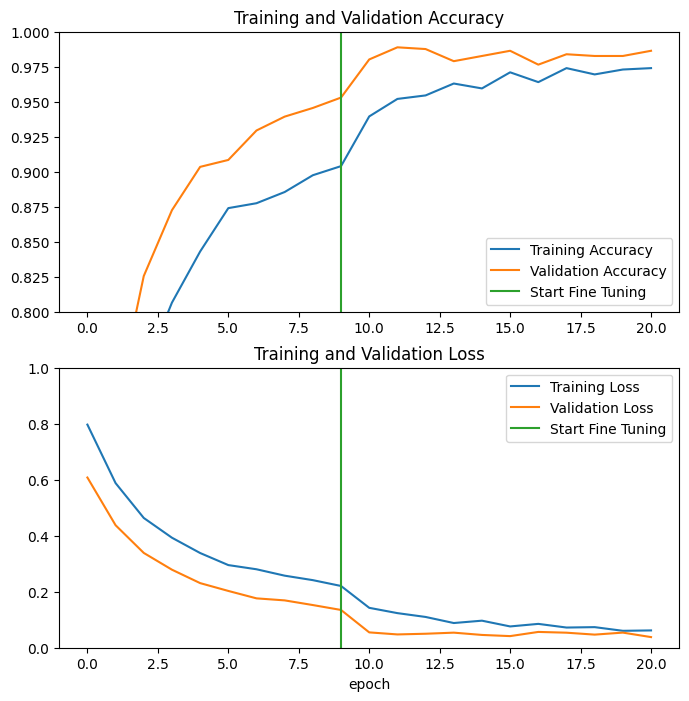

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


1/6 [====>.........................] - ETA: 0s - loss: 0.0914 - accuracy: 0.9375


4/6 [===================>..........] - ETA: 0s - loss: 0.0655 - accuracy: 0.9531


6/6 [==============================] - 0s 19ms/step - loss: 0.0443 - accuracy: 0.9688


Test accuracy : 0.96875


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1]
Labels:
 [1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1]


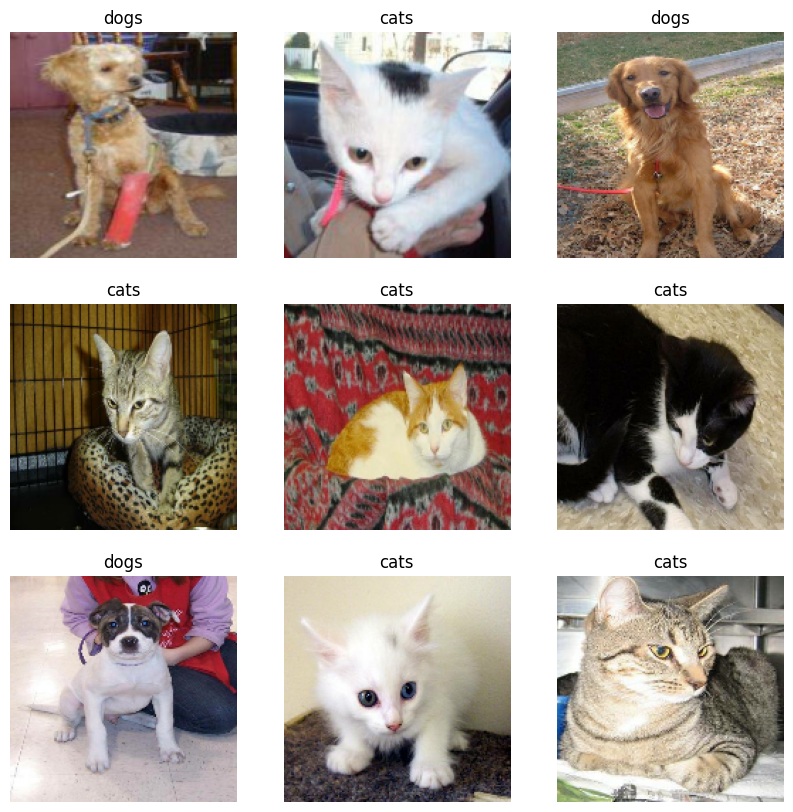

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
